# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
def stream[F[_]: cats.effect.kernel.Async](u: org.http4s.Uri): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, bearerToken))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
extension [A](st: Stream[IO, A])
    def run: List[A] = 
        st.compile.toList.unsafeRunSync()

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
object IsObject: 
    def unapply(v: Json): Option[JsonObject] = 
        v.asObject

In [ ]:
object IsString: 
    def unapply(v: Json): Option[String] = 
        v.asString

In [ ]:
def allCommitPages[F[_]: Async](repo: String): Stream[F, Json] =

    def newPage(i: Int): Stream[F, Json] = 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"))
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

# How to embed `jq`?

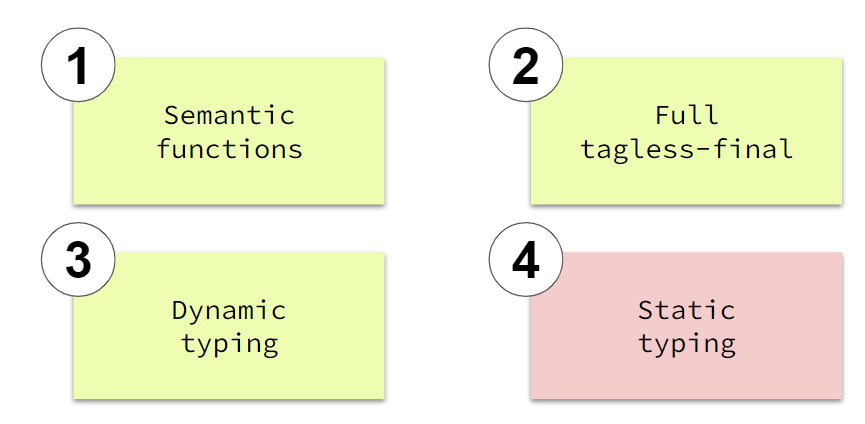

### Jq programs that will _always_ fail

`.[]` may fail

This will always fail: `1 | .[]` [Try it!](https://jqplay.org/s/RRyGSQHDmFc)

How can we ruled out these kinds of programs?

### Type rules

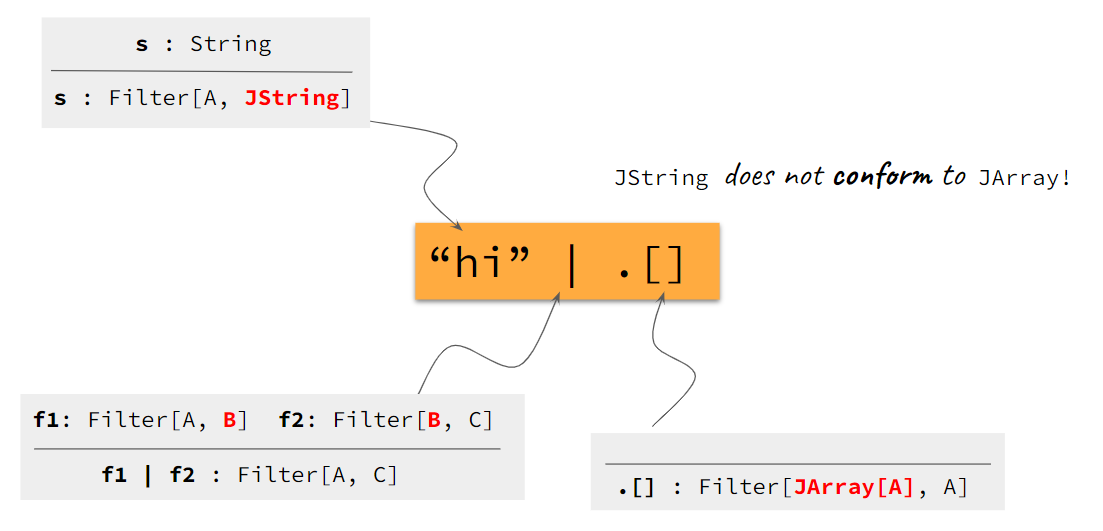

In [ ]:
sealed trait Filter[-I <: JsonT, +O <: JsonT]

enum JsonT:
    case JNullT()
    case JBoolT()
    case JNumberT()
    case JStringT()
    case JArrayT[+t <: JsonT]()
    case JObjectT()

import JsonT._

### Type class update

In [ ]:
trait Jq[R[+_]]: 

    /* Primitive Filters */

    def id[A <: JsonT]: R[Filter[A, A]]
    def str[A <: JsonT](s: String): R[Filter[A, JStringT]]
    def iterator[A <: JsonT]: R[Filter[JArrayT[A], A]]
    def array[A <: JsonT, B <: JsonT](f: R[Filter[A, B]]): R[Filter[A, JArrayT[B]]]
    def error[A <: JsonT](msg: String): R[Filter[A, Nothing]]
    
    extension [A <: JsonT, B <: JsonT](f1: R[Filter[A, B]])
        def |[C <: JsonT](f2: R[Filter[B, C]]): R[Filter[A, C]]
        def concat(f2: R[Filter[A, B]]): R[Filter[A, B]]
        def `catch`(f2: R[Filter[A, B]]): R[Filter[A, B]]

    extension [A <: JsonT](f1: R[Filter[A, JObjectT]])
        def index(f2: R[Filter[A, JStringT]]): R[Filter[A, Nothing]]

    /* built-in functions */

    def map[A <: JsonT, B <: JsonT](f: R[Filter[A, B]]): R[Filter[JArrayT[A], JArrayT[B]]] = 
        array(iterator | f)

object Jq: 

    def apply[R[+_]](using J: Jq[R]): Jq[R] = J

    object syntax: 
        def id[R[+_], A <: JsonT](using J: Jq[R]) = J.id[A] 
        def str[R[+_], A <: JsonT](using J: Jq[R])(s: String) = J.str[A](s)
        def iterator[R[+_], A <: JsonT](using J: Jq[R]) = J.iterator[A]
        def error[R[+_], A <: JsonT](msg: String)(using J: Jq[R]) = J.error[A](msg)

        def arr[R[+_], A <: JsonT, B <: JsonT](f: R[Filter[A, B]]*)(using J: Jq[R]) = 
            J.array(f.reduce(_ concat _))

        extension [R[+_]](sc: StringContext)(using J: Jq[R])
            def i(args: R[Filter[JsonT, Nothing]]*) = 
                sc.s().split('.').toList.map(key => J.id.index(J.str(key))).reduce(_ | _)

    enum Error: 
        case CannotIterateOver(j: Json)
        case CannotIndexObjectWith(j: Json)
        case CannotIndex(j: Json)
        case Custom(msg: String = "")


### Well-formed & malformed programs

In [ ]:
import Jq.syntax._

In [ ]:
def program[R[+_]](using J: Jq[R]): R[Filter[JsonT, JStringT /*JsonT*/]] = 
    arr(str("1"), str("2"), str("3")) | iterator

In [ ]:
def program[R[+_]: Jq] = 
    str("1") | iterator

### Fs2 semantics update

In [ ]:
object Fs2:

    type Filter[F[_]] = 
        Pipe[F, io.circe.Json, io.circe.Json | Jq.Error]

    given [F[_]]: Jq[[t] =>> Filter[F]] with 
    
        def id[A <: JsonT]: Filter[F] = 
            identity

        def str[A <: JsonT](s: String): Filter[F] = 
            _ map: _ => 
                Json.fromString(s)

        def iterator[A <: JsonT]: Filter[F] = 
            _ flatMap:
                case IsArray(v) => Stream(v*)
                case j => Stream(Jq.Error.CannotIterateOver(j))

        def array[A <: JsonT, B <: JsonT](f: Filter[F]): Filter[F] =
            _ flatMap: json => 
                f(Stream(json))
                    .fold(List[Json|Jq.Error]())(_ :+ _)
                    .flatMap: content => 
                        content.lastOption match
                            case Some(error: Jq.Error) => Stream(error)
                            case _ => Stream(Json.arr(content.collect{ case j: Json => j }*))

        def error[A <: JsonT](msg: String): Filter[F] = 
            _ map: _ => 
                Jq.Error.Custom(msg)

        extension  [A <: JsonT, B <: JsonT](f1: Filter[F])
            def |[C <: JsonT](f2: Filter[F]): Filter[F] = 
                _ flatMap: v => 
                    f1(Stream(v)).flatMap:
                        case e: Jq.Error => Stream(e)
                        case j: Json => 
                            f2(Stream(j)).takeThrough: 
                                case j: Json => true
                                case _ => false

            def concat(f2: Filter[F]): Filter[F] = 
                _.flatMap: json => 
                    (f1(Stream(json)) ++ f2(Stream(json)))
                        .takeThrough: 
                            case j: Json => true
                            case _ => false

            def `catch`(f2: Filter[F]): Filter[F] = 
                _ flatMap: j => 
                    f1(Stream(j)) flatMap:
                        case j: Json => Stream(j)
                        case e: Jq.Error => 
                            f2(Stream(Json.fromString(e.toString)))

        extension [A <: JsonT](f1: Filter[F])
            private def indexObj(key: String)(v: Json): Stream[F, Json | Jq.Error] = 
                f1(Stream(v)) map: 
                    case IsObject(obj) => obj(key).getOrElse(Json.Null)
                    case j: Json => Jq.Error.CannotIndex(j)
                    case error => error

            def index(f2: Filter[F]): Filter[F] = 
                _ flatMap: v => 
                    f2(Stream(v)) flatMap:
                        case IsString(s) => indexObj(s)(v)
                        case k: Json => Stream(Jq.Error.CannotIndexObjectWith(k))
                        case error => Stream(error)

In [ ]:
{
    import Fs2.given
    
    Stream(Json.Null).through(program[[t] =>> Fs2.Filter[IO]]).run
}

### A case for `match types`

In [ ]:
sealed trait Filter[-I <: JsonT, +O <: JsonT]

enum JsonT:
    case JNullT()
    case JBoolT()
    case JNumberT()
    case JStringT()
    case JArrayT[+t <: JsonT]()
    case JObjectT()

import JsonT._

In [ ]:
type IndexType[T <: JsonT] <: JsonT = T match 
    case JObjectT => JStringT
    case JArrayT[_] => JNumberT    

In [ ]:
type OutputType[T1 <: JsonT] <: JsonT = T1 match 
    case JArrayT[t] => t
    case JObjectT => JsonT

In [ ]:
trait Jq[R[+_]]: 
    extension (i: Int)
        def int[T <: JsonT]: R[Filter[T, JNumberT]]

    extension (s: String)
        def str[T <: JsonT]: R[Filter[T, JStringT]]

    def id[T <: JsonT]: R[Filter[T, T]]
    
    extension [T1 <: JsonT, T <: JsonT, T2 <: JArrayT[T] | JObjectT](
        f1: R[Filter[T1, T2]]) 
        def index(f: R[Filter[T1, IndexType[T2]]]): R[Filter[T1, OutputType[T2]]]

# References

* Match types: https://docs.scala-lang.org/scala3/reference/new-types/match-types.html